In [16]:
from time import time, process_time
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from utility import *

homedir = get_homedir()

In [2]:
import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [32]:
deaths = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties.csv")
deaths.dropna(inplace=True)
deaths['fips'] = deaths['fips'].apply(correct_FIPS)
deaths['date'] = pd.to_datetime(deaths['date'])
deaths.drop(columns=['county', 'state', 'cases'], inplace=True)
deaths = fix_FIPS(deaths, fipslabel='fips', datelabel='date', reduced=True)
deaths.rename(columns={'date':'ds', 'deaths':'y'}, inplace=True)
deaths.tail()

,ds,fips,y
85877,2020-04-24,56035,0
85878,2020-04-24,56037,0
85879,2020-04-24,56039,1
85880,2020-04-24,56041,0
85881,2020-04-24,56043,0


In [36]:
timedel = pd.Timestamp('2020-06-30')-deaths['ds'].max()
timedel.days

67

In [20]:
FIPSlist = sorted(set(deaths['fips']))

In [39]:
fips = '06037'

model = Prophet(interval_width=0.9)
model.fit(deaths[deaths['fips']==fips])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


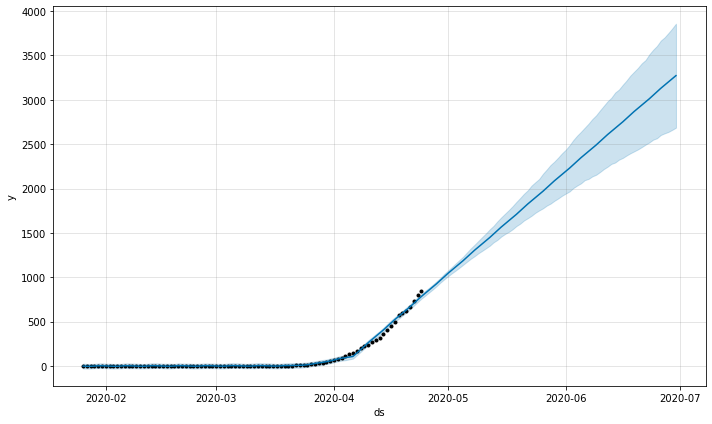

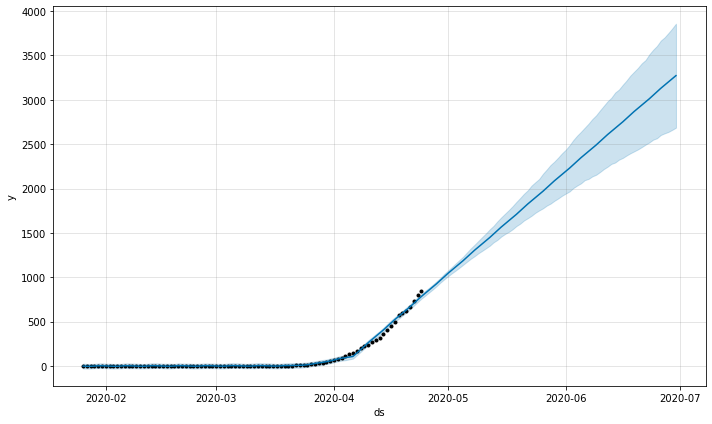

In [38]:
future = model.make_future_dataframe(periods=timedel.days)
forecast = model.predict(future)
model.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


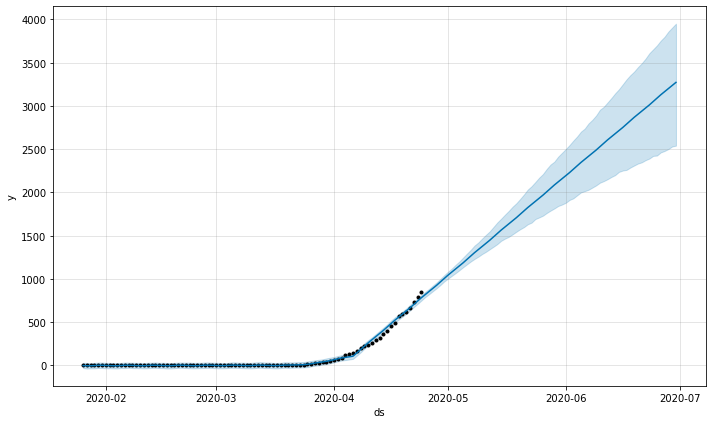

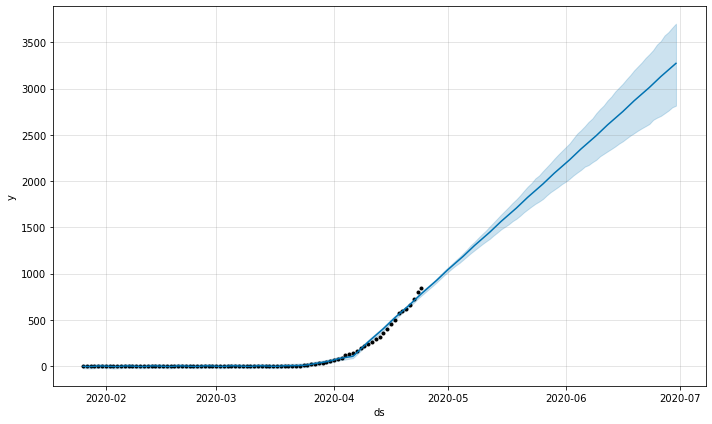

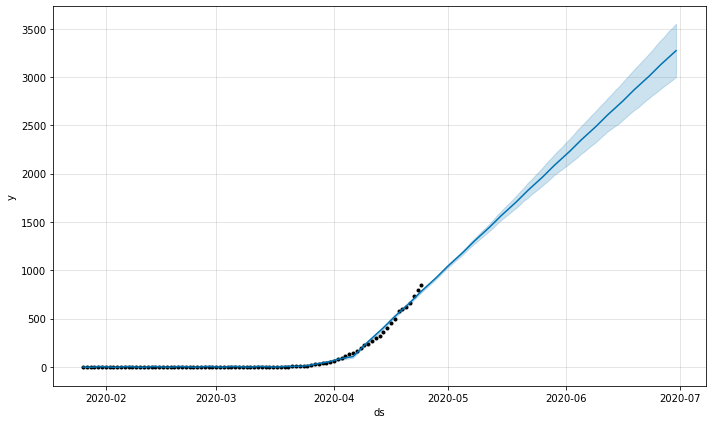

In [41]:
for i in [0.95, 0.8, 0.6]:
    model = Prophet(interval_width=i)
    model.fit(deaths[deaths['fips']==fips])
    future = model.make_future_dataframe(periods=timedel.days)
    forecast = model.predict(future)
    model.plot(forecast)

In [47]:
predict_prophet = pd.DataFrame(columns=['ds', 'fips', 'yhat', 'yhat_lower', 'yhat_upper'])
for fips in FIPSlist:
    df = deaths[deaths['fips']==fips]
    if len(df)>1:
        print('running prediction on ', fips)
        model = Prophet(interval_width=0.6, weekly_seasonality=True, seasonality_mode='multiplicative')
        model.fit(df)
        future = model.make_future_dataframe(periods=timedel.days)
        forecast = model.predict(future)
        forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        forecast['fips'] = [fips]*len(forecast.index)
        predict_prophet = predict_prophet.append(forecast, ignore_index=True)
predict_prophet.head()

nality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
running prediction on  55031
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
running prediction on  55033
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
running prediction on  55035
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
running prediction on  55037
INFO:fbprophet:Disabling yearly seasonality. Run prophet 

,ds,fips,yhat,yhat_lower,yhat_upper
0,2020-03-24,01001,-0.259730,-0.492771,0.012510
1,2020-03-25,01001,-0.291242,-0.542321,-0.037564
2,2020-03-26,01001,-0.252530,-0.491897,-0.003492
3,2020-03-27,01001,-0.156553,-0.403815,0.090244
4,2020-03-28,01001,-0.075383,-0.315573,0.186192


In [48]:
predict_prophet.to_csv('predict_prophet.csv')

In [32]:
predict_prophet = pd.read_csv('predict_prophet.csv', index_col=0)
predict_prophet['fips'] = predict_prophet['fips'].apply(correct_FIPS)
predict_prophet['ds'] = pd.to_datetime(predict_prophet['ds'])
predict_prophet = predict_prophet[predict_prophet['ds']>=pd.Timestamp('2020-04-01')]
predict_prophet.head()

,ds,fips,yhat,yhat_lower,yhat_upper
8,2020-04-01,01001,0.235553,0.009641,0.497756
9,2020-04-02,01001,0.363399,0.111830,0.617828
10,2020-04-03,01001,0.429479,0.183394,0.701567
11,2020-04-04,01001,0.531157,0.282404,0.804181
12,2020-04-05,01001,0.576653,0.344745,0.804388


In [39]:
fips = '06037'
pr_min, pr_max = predict_prophet[predict_prophet['fips']==fips]['yhat_lower'].to_numpy(), predict_prophet[predict_prophet['fips']==fips]['yhat_upper'].to_numpy()
# pr_med = predict_prophet[predict_prophet['fips']==fips]['yhat'].to_numpy()
# pr_min.head()

for i in range(5):
    a, b = np.linalg.solve(np.array([[norm.ppf(0.2), 1], [norm.ppf(0.8), 1]]), np.array([pr_min[i], pr_max[i]]))
    print(a*np.array(norm.ppf(np.linspace(0.1, 0.9, num=9)))+b)

[48.34599312 54.77817997 59.41623922 63.37928984 67.08345794 70.78762604
 74.75067666 79.38873592 85.82092276]
[58.91782855 65.63328098 70.47559465 74.61317313 78.48046824 82.34776334
 86.48534183 91.3276555  98.04310793]
[ 68.38803968  74.80326429  79.42909258  83.38169229  87.07609218
  90.77049207  94.72309179  99.34892008 105.76414468]
[ 74.08323182  80.7231315   85.51096631  89.60199463  93.42578041
  97.24956619 101.34059451 106.12842933 112.768329  ]
[ 81.36461802  87.78329768  92.41161731  96.36634578 100.06273537
 103.75912496 107.71385342 112.34217305 118.76085272]


In [43]:
predict_prophet[predict_prophet['fips']=='01031']

,ds,fips,yhat,yhat_lower,yhat_upper
1472,2020-04-02,01031,-0.320210,-0.458408,-0.171344
1473,2020-04-03,01031,-0.000025,-0.155385,0.135833
1474,2020-04-04,01031,-0.000111,-0.140077,0.146297
1475,2020-04-05,01031,-0.000023,-0.136599,0.146952
1476,2020-04-06,01031,0.000025,-0.131132,0.144595
...,...,...,...,...,...
1557,2020-06-26,01031,0.000343,-0.155414,0.136051
1558,2020-06-27,01031,0.001844,-0.139802,0.152045
1559,2020-06-28,01031,0.000485,-0.141524,0.138471
1560,2020-06-29,01031,-0.000749,-0.142853,0.140555


In [44]:
days_to_str = [f'2020-04-0{i}' for i in range(1, 10)] + [f'2020-04-{i}' for i in range(10, 31)] + [f'2020-05-0{i}' for i in range(1, 10)] + [f'2020-05-{i}' for i in range(10, 32)] + [f'2020-06-0{i}' for i in range(1, 10)] + [f'2020-06-{i}' for i in range(10, 31)]
FIPS_prophet = sorted(set(predict_prophet['fips'].to_numpy()))

pred_quant = []
for fips in FIPS_prophet:
    pr_min, pr_max = predict_prophet[predict_prophet['fips']==fips]['yhat_lower'].to_numpy(), predict_prophet[predict_prophet['fips']==fips]['yhat_upper'].to_numpy()
    missingday = 91-len(pr_min)
    for i in range(len(pr_min)):
        a, b = np.linalg.solve(np.array([[norm.ppf(0.2), 1], [norm.ppf(0.8), 1]]), np.array([pr_min[i], pr_max[i]]))
        pred_quant.append([days_to_str[i+missingday], fips] + list(a*np.array(norm.ppf(np.linspace(0.1, 0.9, num=9)))+b))

df_predict = pd.DataFrame(pred_quant, columns=['date', 'fips']+[f'{10*i}' for i in range(1,10)])
df_predict = fix_FIPS(df_predict, fipslabel='fips', datelabel='date', reduced=False)
df_predict.dropna(inplace=True)
df_predict[df_predict['fips']=='06037']

,date,fips,10,20,30,40,50,60,70,80,90
153,2020-04-01,06037,48.345993,54.778180,59.416239,63.379290,67.083458,70.787626,74.750677,79.388736,85.820923
2341,2020-04-02,06037,58.917829,65.633281,70.475595,74.613173,78.480468,82.347763,86.485342,91.327656,98.043108
4605,2020-04-03,06037,68.388040,74.803264,79.429093,83.381692,87.076092,90.770492,94.723092,99.348920,105.764145
6931,2020-04-04,06037,74.083232,80.723131,85.510966,89.601995,93.425780,97.249566,101.340595,106.128429,112.768329
9305,2020-04-05,06037,81.364618,87.783298,92.411617,96.366346,100.062735,103.759125,107.713853,112.342173,118.760853
...,...,...,...,...,...,...,...,...,...,...,...
235099,2020-06-26,06037,2845.634047,2976.664429,3071.146553,3151.878044,3227.335827,3302.793611,3383.525102,3478.007226,3609.037607
237884,2020-06-27,06037,2778.574748,2910.130286,3004.991085,3086.046140,3161.806350,3237.566560,3318.621615,3413.482414,3545.037952
240669,2020-06-28,06037,2752.533862,2882.992750,2977.062787,3057.442165,3132.570836,3207.699507,3288.078885,3382.148922,3512.607810
243454,2020-06-29,06037,2686.500452,2819.032233,2914.596972,2996.253518,3072.575927,3148.898336,3230.554882,3326.119621,3458.651402


In [45]:
from functools import reduce

reindexer = {}
for i in range(len(df_predict)):
    reindexer[df_predict.index[i]] = reduce((lambda x, y: x+f'-{int(y)}'), df_predict.iloc[i][['date', 'fips']].tolist())

df_predict = df_predict.rename(index=reindexer).rename_axis('id').drop(['date', 'fips'], axis=1)
df_predict.head()

,10,20,30,40,50,60,70,80,90
id,,,,,,,,,
2020-04-01-1001,-1.179315e-01,9.641478e-03,1.016306e-01,1.802319e-01,2.536986e-01,3.271654e-01,4.057667e-01,4.977558e-01,6.253288e-01
2020-04-01-1003,3.481050e-01,5.262062e-01,6.546296e-01,7.643627e-01,8.669276e-01,9.694925e-01,1.079226e+00,1.207649e+00,1.385750e+00
2020-04-01-1007,-1.363545e-09,-9.209335e-10,-6.017798e-10,-3.290747e-10,-7.418379e-11,1.807071e-10,4.534122e-10,7.725659e-10,1.215177e-09
2020-04-01-1009,-1.217422e-09,-7.833192e-10,-4.703007e-10,-2.028379e-10,4.715319e-11,2.971442e-10,5.646070e-10,8.776256e-10,1.311728e-09
2020-04-01-1011,-1.302898e-09,-8.581980e-10,-5.375383e-10,-2.635464e-10,-7.452802e-12,2.486408e-10,5.226327e-10,8.432924e-10,1.287992e-09


In [46]:
YuLi = pd.read_csv('First91days_highlowdeath_daily.csv')
YuLi.set_index('id', inplace=True)
YuLi.head()

,10,20,30,40,50,60,70,80,90
id,,,,,,,,,
2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
YuLi.update(df_predict)

In [48]:
YuLi.reset_index(inplace=True)
YuLi.head()

,id,10,20,30,40,50,60,70,80,90
0,2020-04-01-10001,0.565888,1.348202,1.912305,2.394310,2.844829,3.295348,3.777353,4.341456,5.123770
1,2020-04-01-10003,4.452377,4.767799,4.995241,5.189582,5.371228,5.552873,5.747214,5.974656,6.290079
2,2020-04-01-10005,1.602084,1.862787,2.050772,2.211398,2.361532,2.511665,2.672291,2.860276,3.120979
3,2020-04-01-1001,-0.117932,0.009641,0.101631,0.180232,0.253699,0.327165,0.405767,0.497756,0.625329
4,2020-04-01-1003,0.348105,0.526206,0.654630,0.764363,0.866928,0.969492,1.079226,1.207649,1.385750


In [49]:
from datetime import datetime

mdhm = datetime.now().strftime('%m%d') + '_' + datetime.now().strftime('%H%M')
YuLi.to_csv(f'{homedir}/submissions/submission_fbprophet_{mdhm}.csv', index=False)